### Importations

In [7]:
import os
import numpy as np
import xarray as xr
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes
from typing import List, Tuple, TypeAlias
subplot_1D_type: TypeAlias = Tuple[Figure, List[Axes]]
subplot_2D_type: TypeAlias = Tuple[Figure, List[List[Axes]]]
plt.rc('text', usetex=True)
plt.rcParams.update({
    'text.usetex': True,
    'figure.figsize': (8, 5),
    'axes.titlesize': 18,
    'figure.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6
})

data disponible at
https://github.com/glwagner/SingleColumnModelCalibration.jl?tab=readme-ov-file

# Run forward *Tunax* LES simulations

In [14]:
from tunax import Obs, SingleColumnModel
from tunax.closures import KepsParameters
import jax.numpy as jnp
from jax import vmap
import equinox as eqx
import numpy as np
import os

timeframe_list = [6, 12, 24, 48, 72]
space_step_list = [1, 2, 4]
forcing_list = [
    'free_convection',
    'weak_wind_strong_cooling',
    'med_wind_med_cooling',
    'strong_wind_weak_cooling',
    'strong_wind',
    'strong_wind_no_rotation',
    'strong_wind_and_sunny'
]

var_names = {
    'variables': {
        'time': 'timeseries/t',
        'zr': 'grid/zᵃᵃᶜ',
        'zw': 'grid/zᵃᵃᶠ',
        'u': 'timeseries/u',
        'v': 'timeseries/v',
        'b': 'timeseries/b',
        'pt': 'timeseries/c'
    },
    'parameters': {
        'nz': 'grid/Nz',
        'fcor': 'parameters/coriolis_parameter'
    },
    'metadatas': {
        'u_str': 'parameters/momentum_flux',
        'b_str': 'parameters/buoyancy_flux',
        'pt_depth': 'parameters/tracer_forcing_depth',
        'pt_timescale': 'parameters/tracer_forcing_timescale',
        'pt_width': 'parameters/tracer_forcing_width',
        'sunny_flux': 'parameters/penetrating_buoyancy_flux'
    }
}

dims = {
    'zr': (None,),
    'zw': (None,),
    'u': (None, 0, 0),
    'v': (None, 0, 0),
    'b': (None, 0, 0),
    'pt': (None, 0, 0)
}

def forcing_passive_tracer(
        z: float,
        omega_p: float,
        lambda_c: float,
        zc: float,
        l_z: float
    ):
    omega_m = omega_p*lambda_c*jnp.sqrt(2*jnp.pi)/l_z
    fz = omega_p*jnp.exp(-(z-zc)**2/(2*lambda_c**2)) + omega_m
    return  fz

def forcing_buoyancy_sunny(
        z: float,
        jb: float,
        eps1: float,
        lambda1: float,
        lambda2: float,
    ):
    fz = -jb*(eps1/lambda1*jnp.exp(z/lambda1) + (1-eps1)/lambda2*jnp.exp(z/lambda2))
    return  fz

In [ ]:
for space_step in space_step_list:
    for timeframe in timeframe_list:
        for forcing in forcing_list:
            print(f'{space_step}m', f'{timeframe}h', forcing)
            filename = os.path.join(
                'k-epsilon_Wagner_LES', 'Wagner_LES',f'{timeframe}_hour_suite',
                f'{space_step}m', f'{forcing}_with_tracer_instantaneous_statistics.jld2')
            output_path = os.path.join('k-epsilon_Wagner_LES', 'tunax_scm_output', 'default_keps', f'{space_step}m_{timeframe}h_{forcing}.nc')
            obs = Obs.from_jld2(filename, var_names, None, dims, eos_tracers='b', do_pt=True)

            # case corrections
            obs: Obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.metadatas['u_str'])
            obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing, obs, (0., -obs.metadatas['b_str']))
            obs: Obs = eqx.tree_at(lambda t: t.case.grav, obs, 9.80665)

            # passive tracer forcing
            omega_p = 1/obs.metadatas['pt_timescale']
            lambda_c = obs.metadatas['pt_width']
            zc = obs.metadatas['pt_depth']
            l_z = obs.trajectory.grid.hbot
            wrapped_forcing_pt = lambda z: forcing_passive_tracer(z, omega_p, lambda_c, -zc, l_z)
            obs: Obs = eqx.tree_at(lambda t: t.case.pt_forcing, obs, wrapped_forcing_pt)
            obs: Obs = eqx.tree_at(lambda t: t.case.pt_forcing_type, obs, 'constant', is_leaf=lambda x: x is None)

            # sunny forcing
            if forcing == 'strong_wind_and_sunny':
                jb = obs.metadatas['sunny_flux']
                eps1 = 0.6
                lambda1 = 1.
                lambda2 = 16.
                b_str = obs.case.b_forcing[1]
                wrapped_forcing_b_sunny = lambda z: forcing_buoyancy_sunny(z, jb, eps1, lambda1, lambda2)
                obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing, obs, wrapped_forcing_b_sunny)
                obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing_type, obs, 'constant', is_leaf=lambda x: x is None)

            traj_wagner = obs.trajectory
            time_frame = float(traj_wagner.time[-1]/3600)
            dt = 10.
            out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
            init_state = traj_wagner.extract_state(0)
            model = SingleColumnModel(time_frame, dt, out_dt, init_state, obs.case, 'k-epsilon', output_path)

            keps_params = KepsParameters()

            model.compute_trajectory_with(keps_params)

4m 6h free_convection
4m 6h weak_wind_strong_cooling


/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""


4m 6h med_wind_med_cooling


/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""


4m 6h strong_wind_weak_cooling


/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""


4m 6h strong_wind


/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""


4m 6h strong_wind_no_rotation


/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""


4m 6h strong_wind_and_sunny


/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""


# Huge plots of Wagner

In [15]:
titles = {
    'free_convection': 'free convection',
    'weak_wind_strong_cooling': 'weak wind\nstrong cooling',
    'med_wind_med_cooling': 'med wind\nmed cooling',
    'strong_wind_weak_cooling': 'strong wind\nweak cooling',
    'strong_wind': 'strong wind',
    'strong_wind_no_rotation': 'strong wind\nno rotation',
    'strong_wind_and_sunny': 'strong wind sunny\n no rotation'
}


def plot_wag(timeframe, space_step):
    sp: subplot_2D_type = plt.subplots(3, 7, sharey=True, figsize=(18, 12))
    fig, [axs_b, axs_uv, axs_pt] = sp

    for i_forcing in range(len(forcing_list)):
        forcing = forcing_list[i_forcing]
        filename = os.path.join(
            'k-epsilon_Wagner_LES', 'Wagner_LES',f'{timeframe}_hour_suite',
            f'{space_step}m', f'{forcing}_with_tracer_instantaneous_statistics.jld2')
        wagner_obs = Obs.from_jld2(filename, var_names, None, dims, eos_tracers='b', do_pt=True)
        wagner_traj = wagner_obs.trajectory
        
        tunax_path = os.path.join('k-epsilon_Wagner_LES', 'tunax_scm_output', 'default_keps', f'{space_step}m_{timeframe}h_{forcing}.nc')
        tunax_ds = xr.load_dataset(tunax_path)
        axs_b[i_forcing].plot(wagner_traj.b[0, :], wagner_traj.grid.zr, 'k', linewidth=1)
        axs_b[i_forcing].plot(wagner_traj.b[-1, :], wagner_traj.grid.zr, 'r')
        axs_b[i_forcing].plot(tunax_ds.b[-1, :], wagner_traj.grid.zr, 'g')
        if i_forcing > 0:
            axs_uv[i_forcing].plot(wagner_traj.u[0, :], wagner_traj.grid.zr, 'k', linewidth=1)
            axs_uv[i_forcing].plot(wagner_traj.u[-1, :], wagner_traj.grid.zr, 'r')
            axs_uv[i_forcing].plot(tunax_ds.u[-1, :], wagner_traj.grid.zr, 'g')
            axs_uv[i_forcing].plot(wagner_traj.v[0, :], wagner_traj.grid.zr, 'k--', linewidth=1)
            axs_uv[i_forcing].plot(wagner_traj.v[-1, :], wagner_traj.grid.zr, 'r--')
            axs_uv[i_forcing].plot(tunax_ds.v[-1, :], wagner_traj.grid.zr, 'g--')
        axs_pt[i_forcing].plot(wagner_traj.pt[0, :], wagner_traj.grid.zr, 'k', linewidth=1)
        axs_pt[i_forcing].plot(wagner_traj.pt[-1, :], wagner_traj.grid.zr, 'r')
        axs_pt[i_forcing].plot(tunax_ds.pt[-1, :], wagner_traj.grid.zr, 'g')
        axs_b[i_forcing].set_title(titles[forcing_list[i_forcing]])
    axs_b[0].set_ylabel(r'$b []$')
    axs_uv[1].set_ylabel(r'$u, v \left[\mathrm m \cdot \mathrm s^{-1}\right]$')
    axs_pt[0].set_ylabel(r'passive tracer $[]$')
    axs_uv[0].plot([], [], 'g', label='tunax')
    axs_uv[0].plot([], [], 'r', label='LES')
    axs_uv[0].plot([], [], 'k', label='u')
    axs_uv[0].plot([], [], 'k--', label='v')
    axs_uv[0].text(-0.0, -40, f'time = {timeframe}h\nspace step = {space_step}m', fontsize=18, horizontalalignment='center')
    axs_uv[0].legend(loc='center')
    axs_uv[0].axis('off')
    axs_b[0].set_ylim(-200, 2)

In [ ]:

def plot_pt(timeframe, space_step, forcing):
    sp: subplot_1D_type = plt.subplots(1, 8, sharey=True, figsize=(20, 5))
    fig, axes = sp

    for i_plt_time in range(8):
        filename = os.path.join(
            'k-epsilon_Wagner_LES', 'Wagner_LES',f'{timeframe}_hour_suite',
            f'{space_step}m', f'{forcing}_with_tracer_instantaneous_statistics.jld2')
        wagner_obs = Obs.from_jld2(filename, var_names, None, dims, eos_tracers='b', do_pt=True)
        wagner_traj = wagner_obs.trajectory

        i_time = i_plt_time*wagner_traj.time.shape[0]//8
        
        tunax_path = os.path.join('k-epsilon_Wagner_LES', 'tunax_scm_output', 'default_keps', f'{space_step}m_{timeframe}h_{forcing}.nc')
        tunax_ds = xr.load_dataset(tunax_path)
        axes[i_plt_time].plot(wagner_traj.b[i_time, :], wagner_traj.grid.zr, 'r')
        axes[i_plt_time].plot(tunax_ds.b[i_time, :], wagner_traj.grid.zr, 'g')
        axes[i_plt_time].set_title(f'time = {wagner_traj.time[i_time]/3600: .2f}h')
    axes[0].plot([], [], 'g', label='tunax')
    axes[0].plot([], [], 'r', label='LES')
    fig.suptitle(f'time = {timeframe}h, space step = {space_step}m, {forcing}, passive tracer')
    axes[0].legend()
    

/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_forma

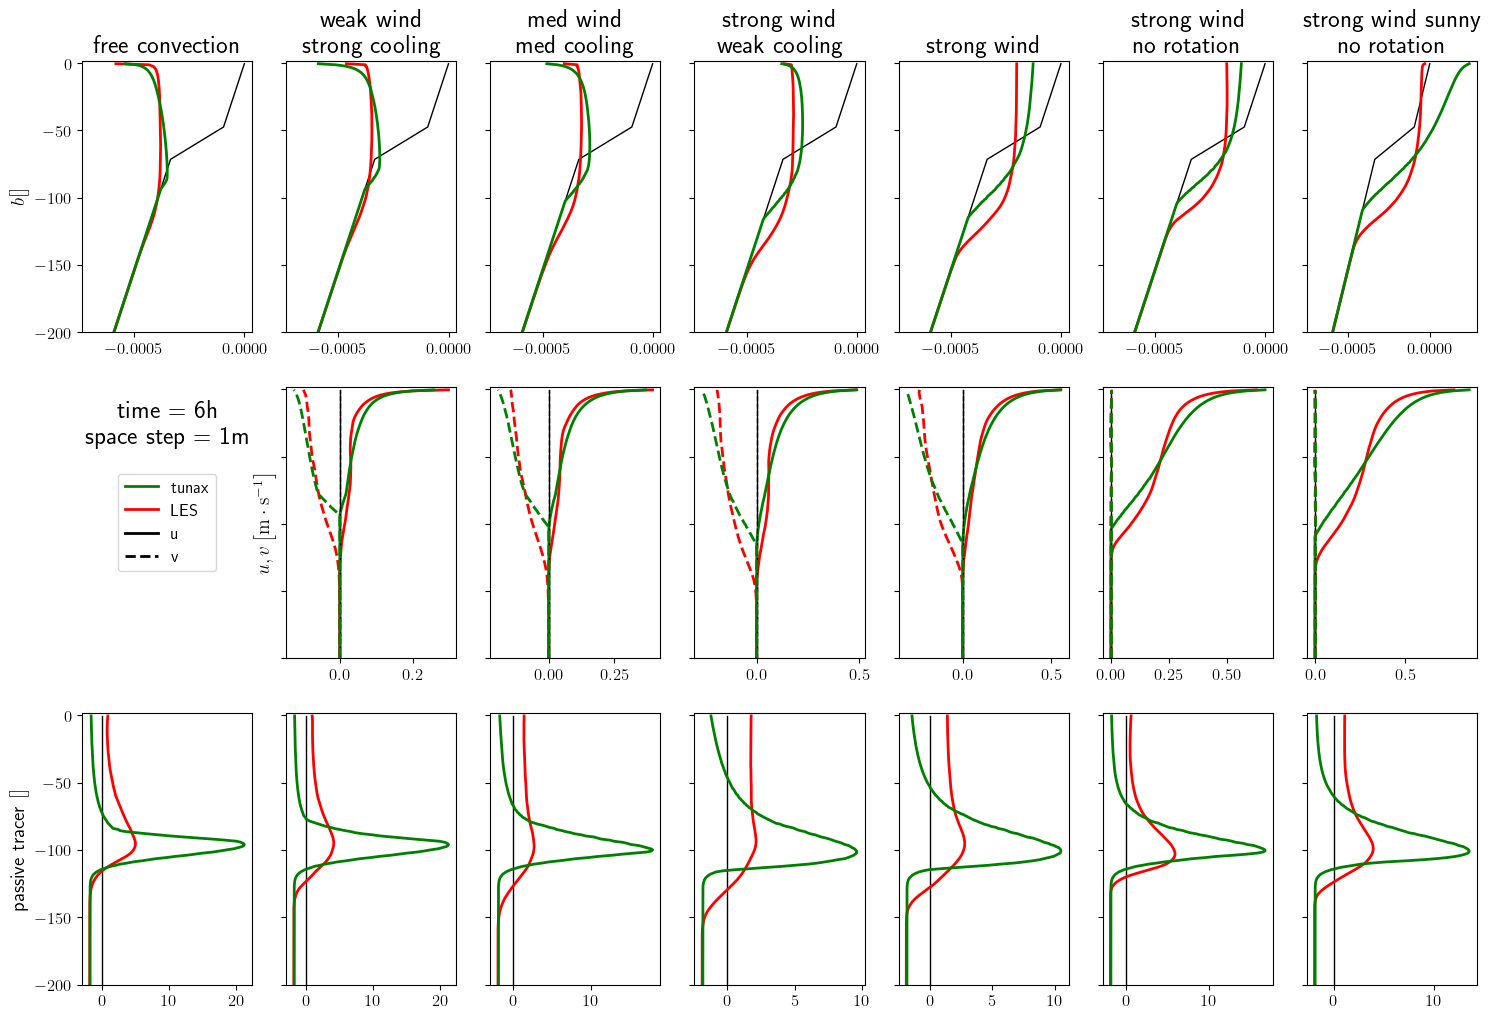

In [7]:
plot_wag(6, 1)

/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""


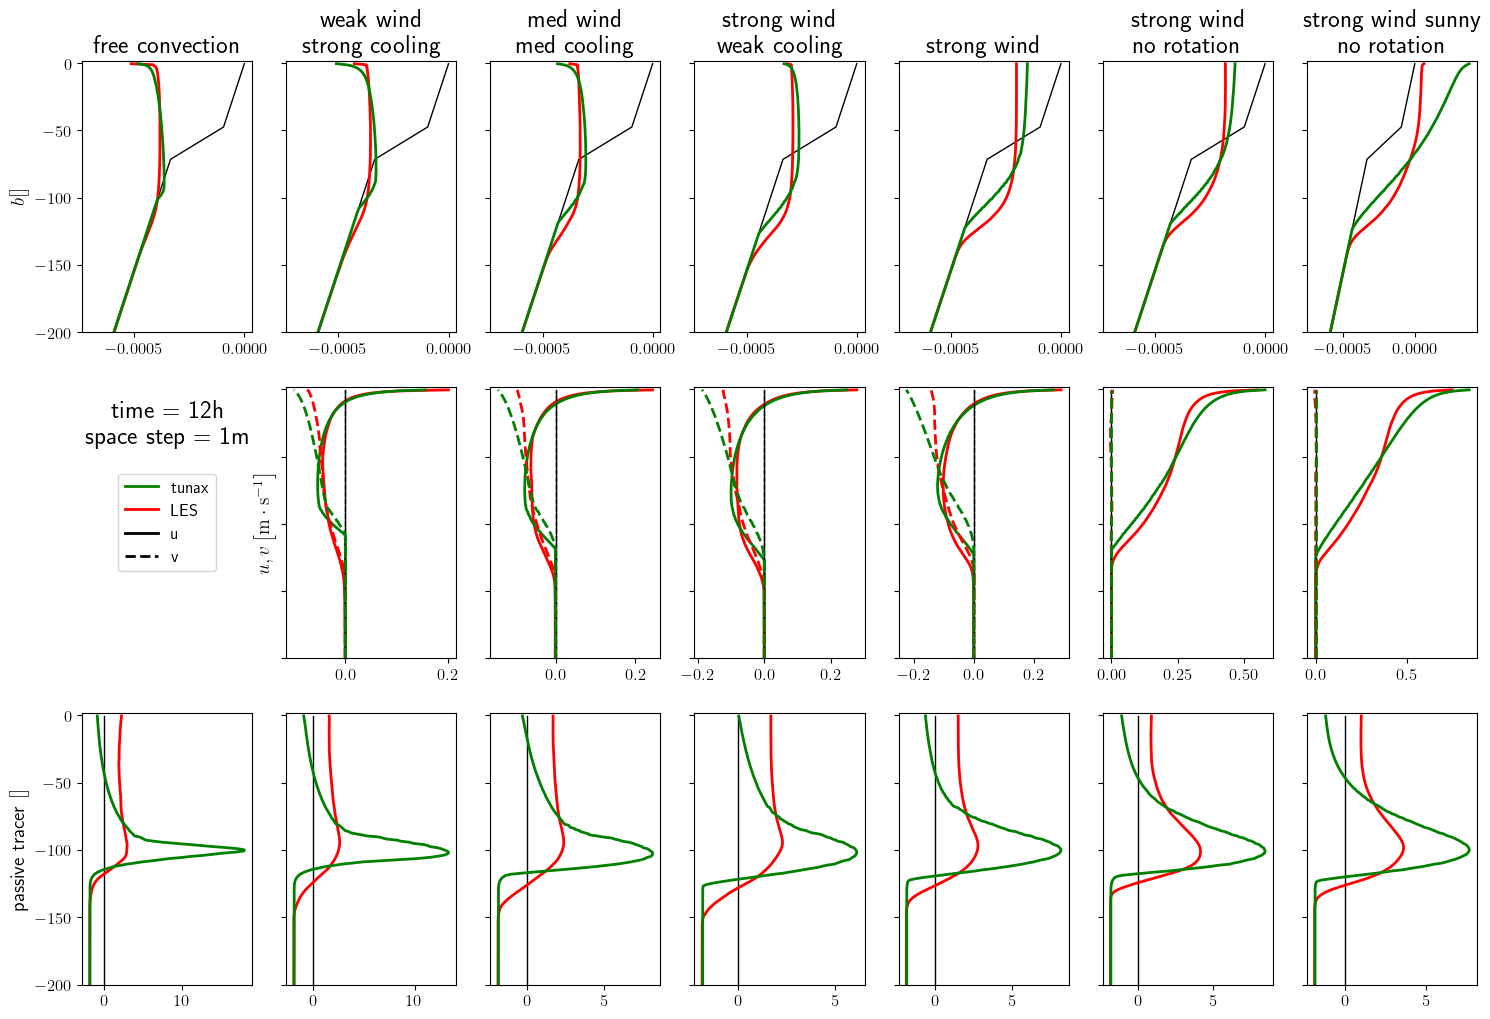

In [8]:
plot_wag(12, 1)

/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""


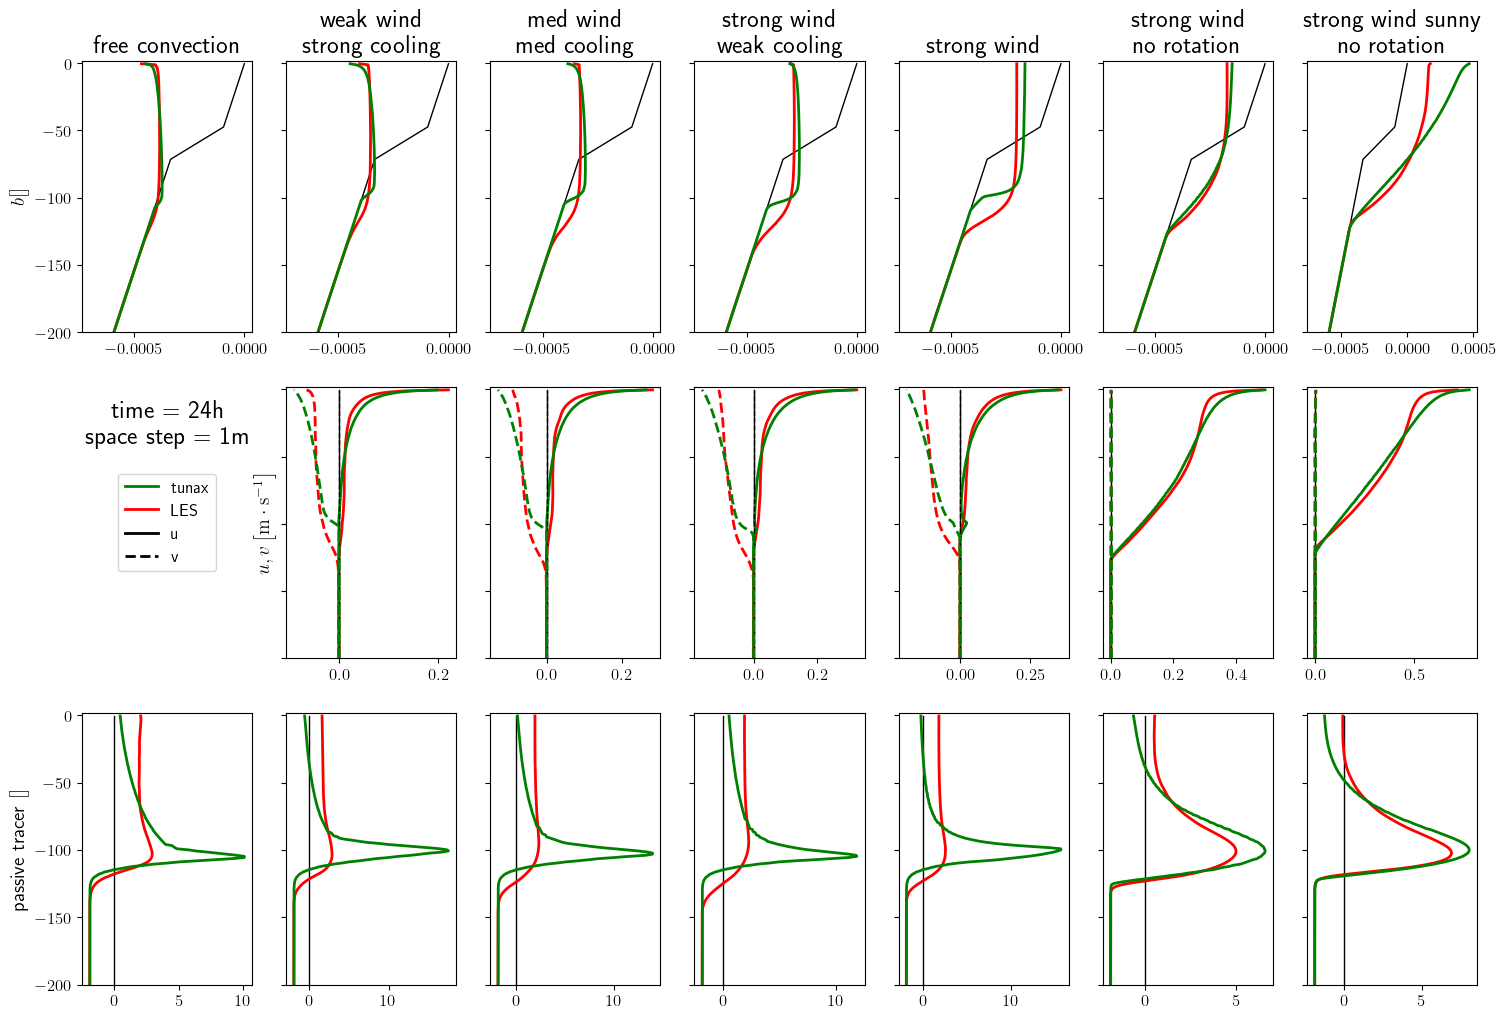

In [9]:
plot_wag(24, 1)

/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""


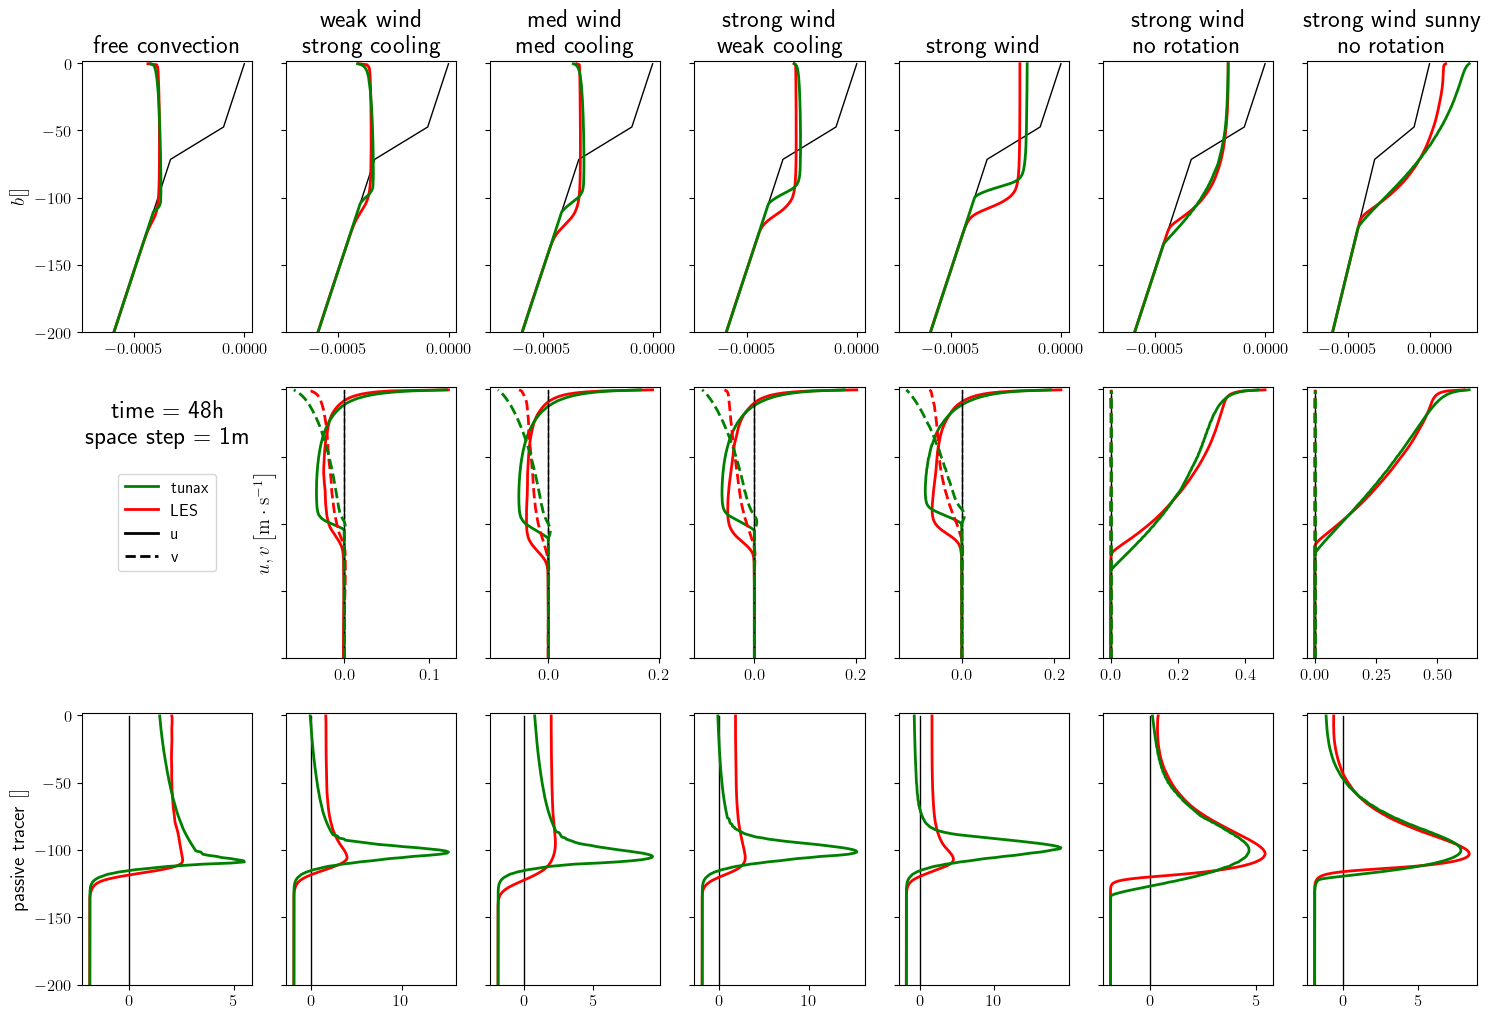

In [10]:
plot_wag(48, 1)

/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""


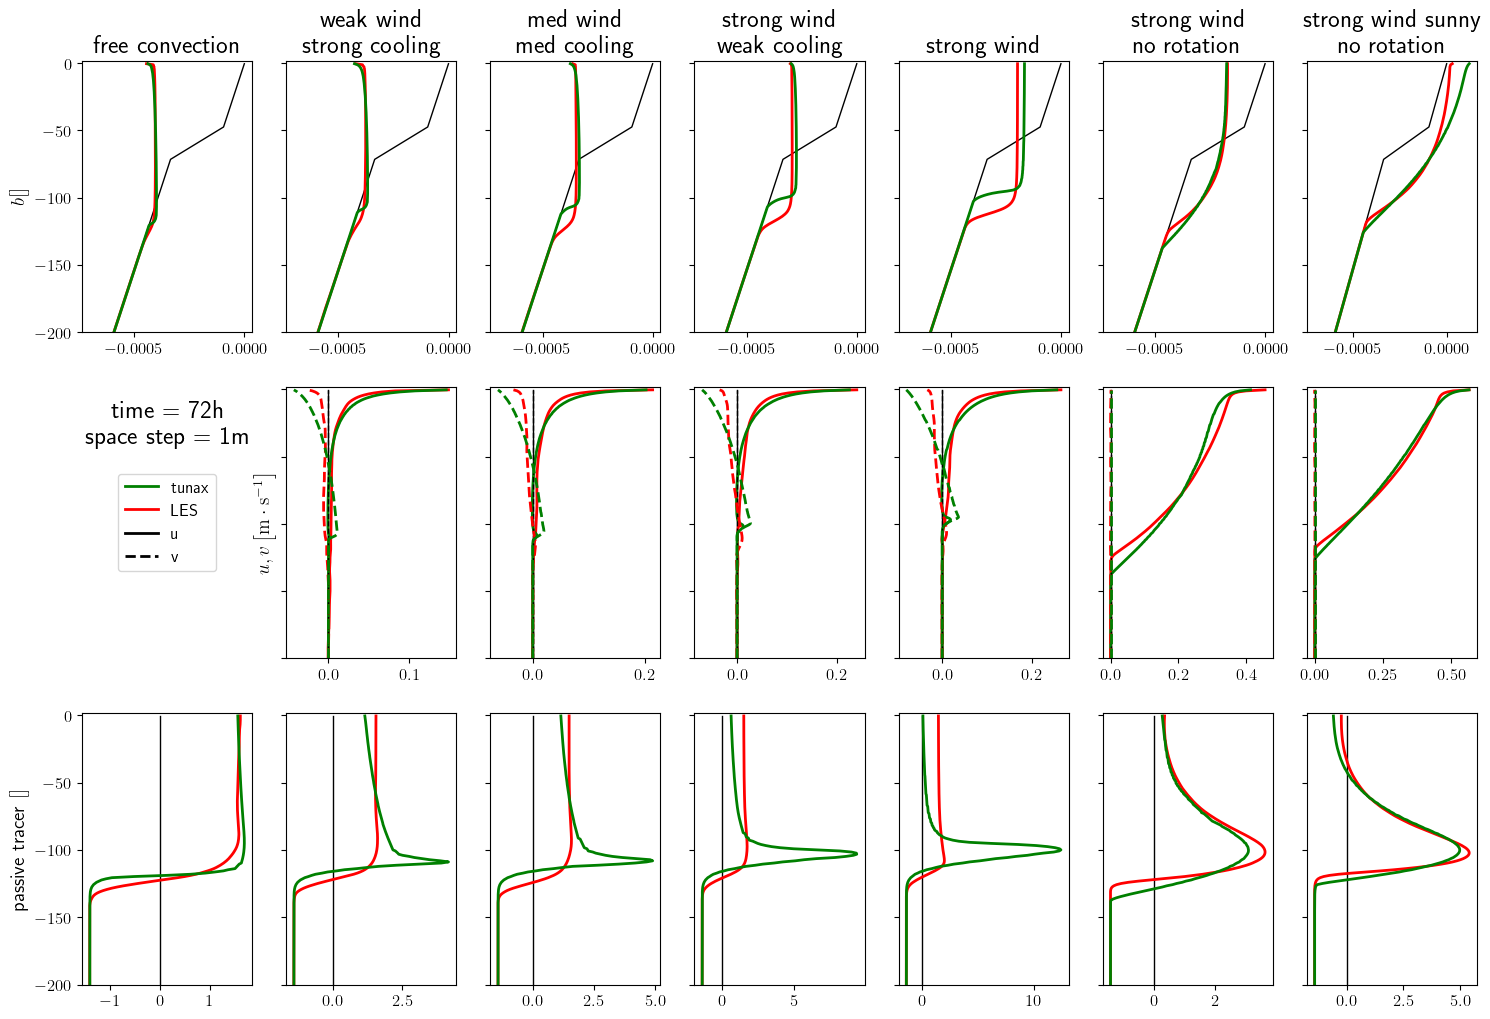

In [11]:
plot_wag(72, 1)

# Calibration fonction de coût

In [1]:
timeframe_list = [6, 12, 24, 48, 72]
space_step_list = [1, 2, 4]
forcing_list = [
    'free_convection',
    'weak_wind_strong_cooling',
    'med_wind_med_cooling',
    'strong_wind_weak_cooling',
    'strong_wind',
    'strong_wind_no_rotation',
    'strong_wind_and_sunny'
]

var_names = {
    'variables': {
        'time': 'timeseries/t',
        'zr': 'grid/zᵃᵃᶜ',
        'zw': 'grid/zᵃᵃᶠ',
        'u': 'timeseries/u',
        'v': 'timeseries/v',
        'b': 'timeseries/b',
        'pt': 'timeseries/c'
    },
    'parameters': {
        'nz': 'grid/Nz',
        'fcor': 'parameters/coriolis_parameter'
    },
    'metadatas': {
        'u_str': 'parameters/momentum_flux',
        'b_str': 'parameters/buoyancy_flux',
        'pt_depth': 'parameters/tracer_forcing_depth',
        'pt_timescale': 'parameters/tracer_forcing_timescale',
        'pt_width': 'parameters/tracer_forcing_width',
        'sunny_flux': 'parameters/penetrating_buoyancy_flux'
    }
}

dims = {
    'zr': (None,),
    'zw': (None,),
    'u': (None, 0, 0),
    'v': (None, 0, 0),
    'b': (None, 0, 0),
    'pt': (None, 0, 0)
}

def forcing_passive_tracer(
        z: float,
        omega_p: float,
        lambda_c: float,
        zc: float,
        l_z: float
    ):
    omega_m = omega_p*lambda_c*jnp.sqrt(2*jnp.pi)/l_z
    fz = omega_p*jnp.exp(-(z-zc)**2/(2*lambda_c**2)) + omega_m
    return  fz

def forcing_buoyancy_sunny(
        z: float,
        jb: float,
        eps1: float,
        lambda1: float,
        lambda2: float,
    ):
    fz = -jb*(eps1/lambda1*jnp.exp(z/lambda1) + (1-eps1)/lambda2*jnp.exp(z/lambda2))
    return  fz

In [2]:
import os
from typing import List

import equinox as eqx
import jax.numpy as jnp
from jaxtyping import Float, Array

from tunax import Obs, Database, FittableParameter, FittableParametersSet, Trajectory, Fitter

# create the database
observations = []
weights = []
variables = []
space_step = 4
for timeframe in timeframe_list:
    for forcing in forcing_list:
        filename = os.path.join(
            'k-epsilon_Wagner_LES', 'Wagner_LES',f'{timeframe}_hour_suite',
            f'{space_step}m', f'{forcing}_with_tracer_instantaneous_statistics.jld2')
        obs = Obs.from_jld2(filename, var_names, None, dims, eos_tracers='b', do_pt=True)

        # case corrections
        obs: Obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.metadatas['u_str'])
        obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing, obs, (0., -obs.metadatas['b_str']))
        obs: Obs = eqx.tree_at(lambda t: t.case.grav, obs, 9.80665)

        # passive tracer forcing
        omega_p = 1/obs.metadatas['pt_timescale']
        lambda_c = obs.metadatas['pt_width']
        zc = obs.metadatas['pt_depth']
        l_z = obs.trajectory.grid.hbot
        wrapped_forcing_pt = lambda z: forcing_passive_tracer(z, omega_p, lambda_c, -zc, l_z)
        obs: Obs = eqx.tree_at(lambda t: t.case.pt_forcing, obs, wrapped_forcing_pt)
        obs: Obs = eqx.tree_at(lambda t: t.case.pt_forcing_type, obs, 'constant', is_leaf=lambda x: x is None)

        # sunny forcing
        if forcing == 'strong_wind_and_sunny':
            jb = obs.metadatas['sunny_flux']
            eps1 = 0.6
            lambda1 = 1.
            lambda2 = 16.
            b_str = obs.case.b_forcing[1]
            wrapped_forcing_b_sunny = lambda z: forcing_buoyancy_sunny(z, jb, eps1, lambda1, lambda2)
            obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing, obs, wrapped_forcing_b_sunny)
            obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing_type, obs, 'constant', is_leaf=lambda x: x is None)
        
        # weight of the observation
        if forcing == 'free_convection':
            weights.append(1.)
            variables.append(['b', 'pt'])
        elif forcing in ['strong_wind_no_rotation', 'strong_wind_and_sunny']:
            weights.append(2/3)
            variables.append(['b', 'pt', 'u'])
        else:
            weights.append(1/2)
            variables.append(['b', 'pt', 'u', 'v'])
        observations.append(obs)
metadatas = {'weights': weights, 'variables': variables}
database = Database(observations, metadatas)

# fonction de normalisation d'un array
def norm_array(x: Float[Array, 'nz']):
    return (x-x.mean())/x.std()

# indices de la zone à sélectionner (pour le space step donné)
grid = database.observations[0].trajectory.grid
i_bot = jnp.searchsorted(grid.zr, grid.hbot/3, side='right')
i_top = jnp.searchsorted(grid.zr, -4, side='left')

# fonction coût
def loss(scm_set: List[Trajectory], database: Database):
    cost = 0.
    for i_obs in range(1):#len(scm_set)-34):
        traj_scm = scm_set[i_obs]
        traj_obs = database.observations[i_obs].trajectory
        for var in database.metadatas['variables'][i_obs]:
            var_scm = getattr(traj_scm, var)
            var_obs = getattr(traj_obs, var)
            end_scm = var_scm[-1, i_bot:i_top]
            end_obs = var_obs[-1, i_bot:i_top]
            norm_scm = norm_array(end_scm)
            norm_obs = norm_array(end_obs)
            var_cost = jnp.sum((norm_scm-norm_obs)**2)
            cost += database.metadatas['weights'][i_obs]*var_cost
    return cost

# parameters on the parameters to calibrate
c_eps1_par = FittableParameter(True, val=1.44)
c_eps2_par = FittableParameter(True, val=1.92)
c_eps3m_par = FittableParameter(True, val=.4)
c_eps3p_par = FittableParameter(True, val=1.)
sig_k_par = FittableParameter(True, val=1.)
sig_eps_par = FittableParameter(True, val=1.3)
coef_dico = {
    'c_eps1': c_eps1_par,
    'c_eps2': c_eps2_par,
    'c_eps3m': c_eps3m_par,
    'c_eps3p': c_eps3p_par,
    'sig_k': sig_k_par,
    'sig_eps': sig_eps_par
}
coef_fit_params = FittableParametersSet(coef_dico, 'k-epsilon')

/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_forma

In [3]:

nloop = 5
learning_rate = .1
dt =100.
verbatim = True
nit_loss = 2
f = Fitter(coef_fit_params, database, dt, loss, nloop, nit_loss, learning_rate, verbatim, 'test.npz')


/Users/admin-mouttaga/Codes/tunax/tunax/model.py:142: UserWarning: The `time_frame`is not proportional to the out time-step `out_dt`, the last step will be computed a few before the `time_frame`.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/model.py:148: UserWarning: The `time_frame`is not proportional to the time-step `dt`, the last step will be computed a few before the time_frame.
  warnings.warn(_format_to_single_line("""


In [4]:
coefs = f()


                    loop 0
                    x [1.44 1.92 0.4  1.   1.   1.3 ]
                    grads [ 0.          1.586294    0.00658472 -1.8148556  -0.04414263  1.0162772 ]
                

                    loop 1
                    x [1.44       1.8200006  0.30000082 1.0999993  1.0999993  1.2000006 ]
                    grads [ 0.         -0.27985045 -0.00968565  0.44531986  0.82280415 -0.20055579]
                

                    loop 2
                    x [1.44       1.7669499  0.32389024 1.1473308  1.0292809  1.1486785 ]
                    grads [ 0.         -3.110468   -0.02530866  3.6784928   2.0768275  -1.6100436 ]
                

                    loop 3
                    x [1.44       1.8048443  0.3896227  1.1069242  0.94974715 1.1809658 ]
                    grads [ 0.         -0.25618383 -0.00930703  0.4328802   0.8048458  -0.1453691 ]
                

                    loop 4
                    x [1.44       1.8400438  0.4591009  1.0679388  0

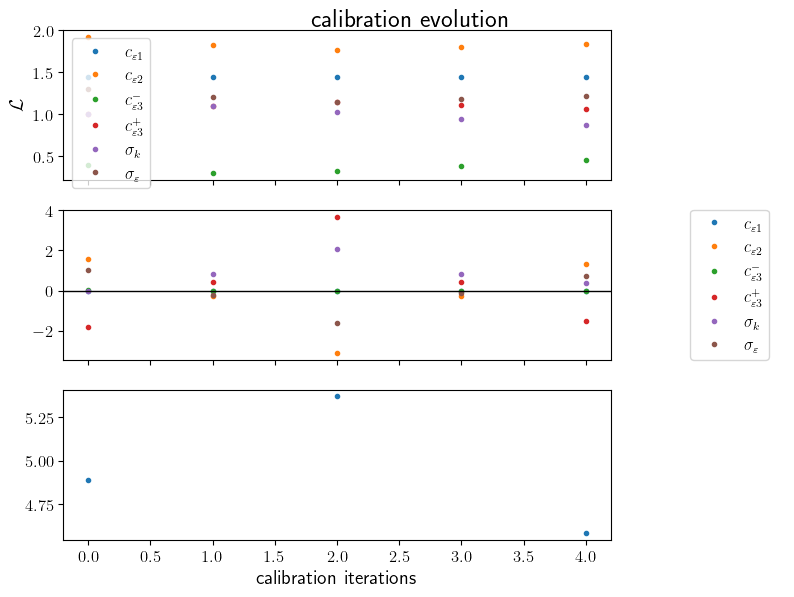

In [8]:
import numpy as np
data = np.load('test.npz', allow_pickle=True)
loss_it = data['loss_it']
loss_values = data['loss_values']

sp: subplot_2D_type = plt.subplots(3, 2, sharex=True, figsize=(8, 6), width_ratios=(5, 1))
fig, [[ax_x, ax1], [ax_g, ax_leg], [ax_l, ax2]] = sp
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

par_names = [
    r'$c_{\varepsilon 1}$',
    r'$c_{\varepsilon 2}$',
    r'$c_{\varepsilon 3}^-$',
    r'$c_{\varepsilon 3}^+$',
    r'$\sigma_k$',
    r'$\sigma_\varepsilon$'
]

for i_par in range(data['x'].shape[0]):
    ax_x.plot(data['x'][i_par, :], '.', label=par_names[i_par])
    ax_leg.plot([], [], '.', label=par_names[i_par])
    ax_g.plot(data['grads'][i_par, :], '.')
ax_g.axhline(0, color='k', linewidth=1)
ax_l.plot(loss_it, loss_values, '.', label=r'$\mathcal L$')

ax_l.set_xlabel('calibration iterations')
ax_x.legend()
ax_x.set_ylabel(r'parameters $c$ calibration')
ax_x.set_ylabel(r'$partial_c \mathcal L$')
ax_x.set_ylabel(r'$\mathcal L$')
fig.suptitle(r'calibration evolution')

ax_leg.legend(loc='center')
ax1.axis('off')
ax_leg.axis('off')
ax2.axis('off')

plt.show()
